In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('/net/mulan/home/huiwann/spatial/SVC/')
import tifffile
from model.train import *
from model.utils import *
import torch 
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import wilcoxon 

In [2]:
data_path = '/net/mulan/home/huiwann/spatial/SVC/' 
dataset = 'data/merfish_U2OS' 
device = 'cuda:1'

In [3]:
gene_names = np.loadtxt(f'{data_path}{dataset}/gene_names.txt', dtype=str)
gene_names = gene_names.tolist()
cell_names = np.loadtxt(f'{data_path}{dataset}/cell_names.txt', dtype=str)

train_merfish_U2OS = np.load(f"{data_path}{dataset}/train_merfish_U2OS.npz")  
train_image = train_merfish_U2OS["data_ori"]
train_cell_morphology = train_merfish_U2OS["cell_morphology"]
train_nuclear_morphology = train_merfish_U2OS["nuclear_morphology"]
train_data_location = train_merfish_U2OS["location"]
train_cell_names = train_merfish_U2OS["cell_names"]
train_dataset = SVC_Dataset(
    data_ori=train_image,
    location=train_data_location,
    cell_morphology_vec=train_cell_morphology,
    nuclear_morphology_vec=train_nuclear_morphology,
)
print("number of training cells:", len(train_dataset),', number of genes:', train_image.shape[1])
train_count_sum = np.load(f'{data_path}output/merfish_U2OS/train_count_sum.npy')
read_dir =f'{data_path}{dataset}/gene2vec_weight_merfish_U2OS.npy'

number of training cells: 900 , number of genes: 119


In [4]:
background_pixel = torch.Tensor([[0,0],[0,1],[0,10],[0,11],[1,0],[1,11],[10,0],[10,11],[11,0],[11,1],[11,10],[11,11]]).to(device).to(torch.long)
foreground = torch.ones((12, 12), dtype=torch.bool, device=device)  # 将背景坐标设为False 
foreground[background_pixel[:, 0], background_pixel[:, 1]] = False
foreground_flat= foreground.flatten().cpu()  # 展平掩码
foreground_expanded = foreground.reshape(1, 1, 12, 12)

In [5]:
spliced_unspliced = np.load(f"{data_path}{dataset}/splice_unsplice.npz")
spliced = spliced_unspliced["splice"]
unspliced = spliced_unspliced["unsplice"]
train_indices = [i for i, name in enumerate(cell_names) if name in train_cell_names]
train_spliced = spliced[train_indices]
train_unspliced = unspliced[train_indices]

In [6]:
ckpt_dir = f"{data_path}checkpoints/"
ckpt = torch.load(ckpt_dir +'SVC_merfish_U2OS.pth', map_location=device)

new_ckpt = {k.replace('module.', ''): v for k, v in ckpt['model_state_dict'].items()}

gene2vec_weight = torch.from_numpy(np.load(read_dir)).float() ##n_gene * 200
print("shape of gene2vec_weight", gene2vec_weight.shape)
# # define ViT model
model = SVC(
    gene2vec_weight = gene2vec_weight,
    use_cell_identity = False,
).to(device)

model_dict = model.state_dict()
for key in model_dict:
    model_dict[key] = new_ckpt[key]
model.load_state_dict(model_dict)


shape of gene2vec_weight torch.Size([119, 200])


<All keys matched successfully>

In [7]:
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = False, num_workers = 4)
cell_median = np.median(train_image.sum((1,2,3)))

model.eval()
all_embeddings_train = []

with torch.no_grad():
    for i, (inputs_ori, cell_morphology, nuclear_morphology, location) in enumerate(train_loader, 0):

        inputs_ori = inputs_ori.to(device).float()
        location = location.to(device).float()
        cell_morphology = cell_morphology.to(device).float()
        nuclear_morphology = nuclear_morphology.to(device).float()

        size_factor = inputs_ori.sum((1,2,3))/cell_median             
        size_factor = size_factor.unsqueeze(1).unsqueeze(2).unsqueeze(3)             
        inputs = inputs_ori / size_factor  # (n_cell, n_gene, 12, 12)

        mask = torch.zeros(inputs.shape[0], inputs.shape[1], dtype=torch.bool, device=device)

        embedding, _, _ = model(inputs, mask, location, cell_morphology, nuclear_morphology)  # (n_cell, n_gene, 12, 12)
        all_embeddings_train.append(embedding)

all_embeddings_train = torch.cat(all_embeddings_train, dim=0) 
embeddings_np = all_embeddings_train.cpu().numpy() 
# np.save("/net/mulan/home/huiwann/spatial/SVC/output/merfish_U2OS/embeddings_train.npy", embeddings_np)

In [ ]:
from sklearn.cluster import SpectralClustering
all_embeddings_train_n = F.normalize(all_embeddings_train, p=2, dim=2, eps=1e-8)   # eps 防止除0
cosine_simi =  torch.bmm(all_embeddings_train, all_embeddings_train.transpose(1, 2)) / ((torch.norm(all_embeddings_train, dim=2, keepdim=True)) * (torch.norm(all_embeddings_train, dim=2, keepdim=True)).transpose(1, 2))  
n_cell = cosine_simi.shape[0]

dist = np.zeros((n_cell, n_cell))

for i in tqdm(range(n_cell)):
    cosine_simi_subset = cosine_simi[i+1:]
    matrix_diff = cosine_simi[i] - cosine_simi_subset
    distance = torch.norm(matrix_diff, p='fro', dim=(1, 2))
    dist[i, (i+1):] = dist[(i+1):,i] = distance.cpu().numpy()

sigma = np.median(dist) 
S = np.exp(-dist ** 2 / (2. * sigma ** 2))
clustering = SpectralClustering(n_clusters=4, affinity='precomputed', random_state=2025)
subcluster_labels = clustering.fit_predict(S)
# np.save(f"{data_path}output/merfish_U2OS/subcluster_labels.npy", subcluster_labels)

100%|██████████| 900/900 [00:00<00:00, 997.93it/s] 


In [16]:
subcluster_labels2 =np.load(f"{data_path}output/merfish_U2OS/subcluster_labels.npy")

In [ ]:
train_cell_names[subcluster_labels==2]

array(['0-32', '16-69', '18-32', '21-54', '27-40', '33-21', '38-26',
       '39-15', '39-55', '40-21'], dtype='<U5')

In [20]:
import umap
reducer = umap.UMAP(random_state=2025)
embeddings_cosine_UMAP = reducer.fit_transform(cosine_simi.cpu().reshape(cosine_simi.shape[0],-1))

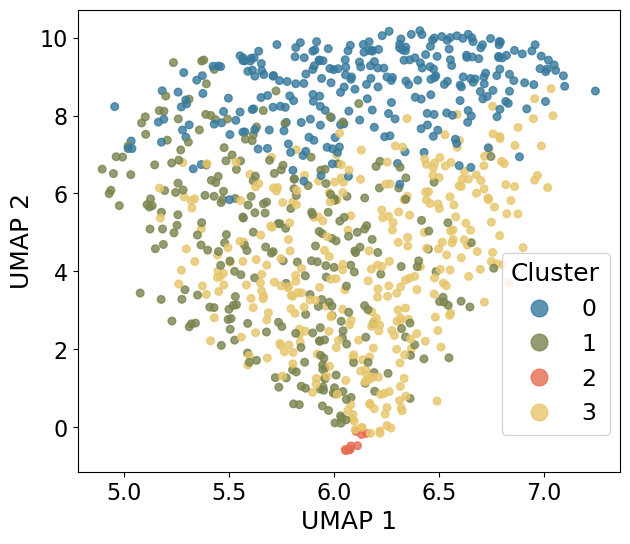

In [24]:
from matplotlib.colors import ListedColormap
class_names = [0,1,2,3]
custom_colors = ['#377A9D','#7A854F','#e66d50','#e7c66b']  
custom_map = ListedColormap(custom_colors)
plt.figure(figsize=(7,6))
ax = plt.scatter(embeddings_cosine_UMAP[:, 1], embeddings_cosine_UMAP[:, 0], alpha=0.8,s=30,c = subcluster_labels,cmap=custom_map)
handles, _ = ax.legend_elements()
plt.legend(handles, class_names, title="Cluster", bbox_to_anchor=(0.76, 0.5), loc='upper left', fontsize=17,title_fontsize=18,markerscale=2)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("UMAP 1", fontsize=18)
plt.ylabel("UMAP 2", fontsize=18)
plt.savefig(f"{data_path}output/merfish_U2OS/figures/UMAP_cell_clusters.png", bbox_inches='tight', dpi=300,transparent=True)
plt.show()

In [25]:
truth_gene_ratio = np.zeros((len(train_cell_names),len(gene_names)))
I = 0
for cell in range(len(train_cell_names)):
    cell_gene_real = train_image[cell]
    J = 0
    for gene in range(len(gene_names)):
        heatmap_real = cell_gene_real[gene,:,:,]
        total_sum_real = np.sum(heatmap_real)

        if total_sum_real != 0:
            ratio_real = 0
            for i in range(heatmap_real.shape[0]):
                for j in range(heatmap_real.shape[1]):
                    ratio_real += np.sqrt((i+0.5-6)**2 + (j+0.5-6)**2)/6 * heatmap_real[i, j]
 
            ratio_real /= total_sum_real
            ratio_real = np.min([ratio_real,1])
            truth_gene_ratio[I,J] = ratio_real

        J += 1
    I += 1

In [ ]:

truth_gene_ratio_mean_0 = truth_gene_ratio[subcluster_labels ==0].sum(0)/(truth_gene_ratio[subcluster_labels ==0]!=0).sum(0)
truth_gene_ratio_mean_1 = truth_gene_ratio[subcluster_labels ==1].sum(0)/(truth_gene_ratio[subcluster_labels ==1]!=0).sum(0)
truth_gene_ratio_mean_2 = truth_gene_ratio[subcluster_labels ==2].sum(0)/(truth_gene_ratio[subcluster_labels ==2]!=0).sum(0)
truth_gene_ratio_mean_3 = truth_gene_ratio[subcluster_labels ==3].sum(0)/(truth_gene_ratio[subcluster_labels ==3]!=0).sum(0)
print("truth_gene_ratio_mean_0:",np.median(truth_gene_ratio_mean_0))
print("truth_gene_ratio_mean_1:",np.median(truth_gene_ratio_mean_1))
print("truth_gene_ratio_mean_2:",np.median(truth_gene_ratio_mean_2))
print("truth_gene_ratio_mean_3:",np.median(truth_gene_ratio_mean_3))
## wilcoxon test
from scipy.stats import wilcoxon

_, p_value01_0 = wilcoxon(truth_gene_ratio_mean_0, truth_gene_ratio_mean_1, alternative='greater')
_, p_value02_0 = wilcoxon(truth_gene_ratio_mean_0, truth_gene_ratio_mean_2, alternative='greater')
_, p_value03_0 = wilcoxon(truth_gene_ratio_mean_0, truth_gene_ratio_mean_3, alternative='greater')
print("p_value0:",p_value01_0)
print("p_value1:",p_value02_0)
print("p_value2:",p_value03_0)

truth_gene_ratio_mean_0: 0.5974604742836019
truth_gene_ratio_mean_1: 0.5972445183605017
truth_gene_ratio_mean_2: 0.5395290134453962
truth_gene_ratio_mean_3: 0.587413919354128
p_value0: 9.138788364589724e-05
p_value1: 2.0470708106711504e-15
p_value2: 6.898841171814021e-16


In [28]:
US_ratio = np.log1p(train_unspliced)-(np.log1p(train_spliced))
US_ratio_0 = US_ratio[subcluster_labels ==0].mean(0)
US_ratio_1 = US_ratio[subcluster_labels ==1].mean(0)
US_ratio_2 = US_ratio[subcluster_labels ==2].mean(0)
US_ratio_3 = US_ratio[subcluster_labels ==3].mean(0)
print("US_ratio_0:",np.median(US_ratio_0))
print("US_ratio_1:",np.median(US_ratio_1))
print("US_ratio_2:",np.median(US_ratio_2)) 
print("US_ratio_3:",np.median(US_ratio_3))
_, p_value01_1 = wilcoxon(US_ratio_0, US_ratio_1,alternative='greater')
_, p_value21_1 = wilcoxon(US_ratio_2, US_ratio_1,alternative='greater')
_, p_value31_1 = wilcoxon(US_ratio_3, US_ratio_1,alternative='greater')
print("p_value0:",p_value01_1)
print("p_value1:",p_value21_1)
print("p_value2:",p_value31_1)

US_ratio_0: -0.6239309194168635
US_ratio_1: -0.6835375071019955
US_ratio_2: -0.01617899730733465
US_ratio_3: -0.6305036684833679
p_value0: 6.610348581258247e-10
p_value1: 3.7350854258913523e-19
p_value2: 2.5406203434975382e-11


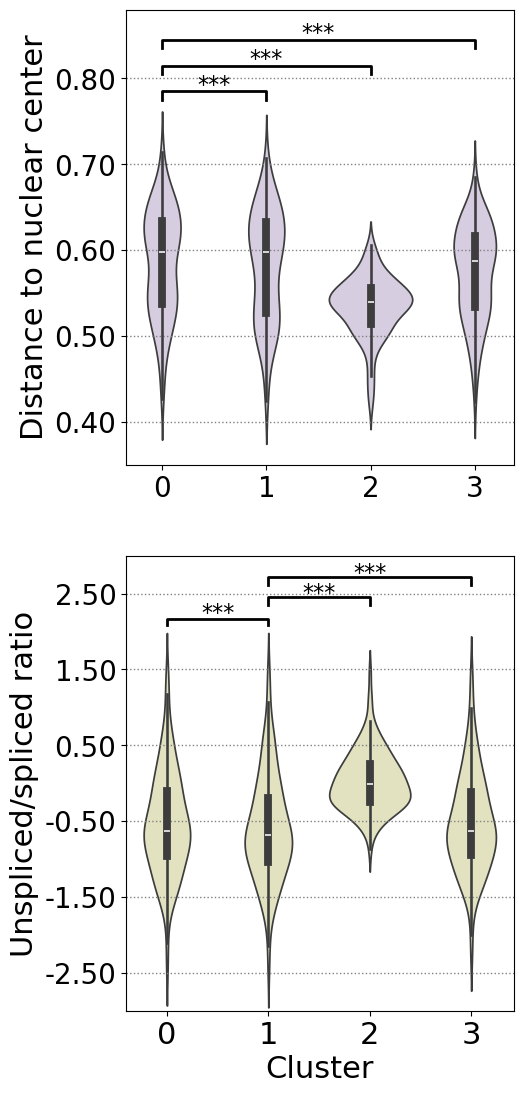

In [ ]:
def get_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'n.s.'  
import seaborn as sns
fig, ax = plt.subplots(2, 1, figsize=(5, 13),  gridspec_kw={ "hspace": 0.2})
sns.violinplot([truth_gene_ratio_mean_0, truth_gene_ratio_mean_1, truth_gene_ratio_mean_2, truth_gene_ratio_mean_3], color='#D7CAE4',ax=ax[0]) #, width=0.5, linewidth=2, showfliers=False,zorder=10
ax[0].set_ylim(0.35,0.88)
# plt.xlim(-0.5,2.5)
ax[0].set_xticks([0,1,2,3], [0,1,2,3],fontsize=20)
ax[0].set_ylabel('Distance to nuclear center', fontsize=22)
ax[0].set_yticks(np.arange(0.4, 0.88, 0.1), ['0.40','0.50','0.60','0.70','0.80'],fontsize=20)
y_offset_inter = 0.05  
y_max = 0.795
fontprops = {'size': 16, 'ha': 'center'}
ax[0].plot([0,0,1,1], 
        [y_max - y_offset_inter+0.03,y_max - y_offset_inter+0.01+0.03,y_max - y_offset_inter+0.01+0.03, y_max - y_offset_inter+0.03], 
        color='black', lw=2, clip_on=False)
ax[0].text(0.5, y_max - y_offset_inter + 0.01+0.03, 
        get_stars(p_value01_0), 
        **fontprops)
ax[0].plot([0,0,2,2], 
        [y_max - y_offset_inter+0.06,y_max - y_offset_inter+0.01+0.06,y_max - y_offset_inter+0.01+0.06, y_max - y_offset_inter+0.06], 
        color='black', lw=2, clip_on=False)
ax[0].text(1, y_max - y_offset_inter+0.06 + 0.01, 
        get_stars(p_value02_0), 
        **fontprops)
ax[0].plot([0,0,3,3], 
        [y_max - y_offset_inter+0.09,y_max - y_offset_inter+0.01+0.09,y_max - y_offset_inter+0.01+0.09, y_max - y_offset_inter+0.09], 
        color='black', lw=2, clip_on=False)
ax[0].text(1.5, y_max - y_offset_inter +0.09 + 0.01, 
        get_stars(p_value03_0), 
        **fontprops)
ax[0].grid(axis='y', color='gray', linestyle=':',linewidth=1)

sns.violinplot([US_ratio_0, US_ratio_1, US_ratio_2, US_ratio_3], color='#e8e7bb',ax=ax[1]) #, width=0.5, linewidth=2, showfliers=False,zorder=10
plt.ylim(-3,3)

plt.xticks([0,1,2,3], fontsize=22)
ax[1].set_xlabel('Cluster', fontsize=22)
ax[1].set_ylabel('Unspliced/spliced ratio', fontsize=22)
y_offset_inter = 0.05  # 组间标注垂直偏移
y_max = 2.15
fontprops = {'size': 16, 'ha': 'center'}
ax[1].plot([0,0,1,1], 
        [y_max - y_offset_inter-0.01,y_max - y_offset_inter+0.07-0.01,y_max - y_offset_inter+0.07-0.01, y_max - y_offset_inter-0.01], 
        color='black', lw=2, clip_on=False)
ax[1].text(0.5, y_max - y_offset_inter + 0.05+0.01, 
        get_stars(p_value01_1), 
        **fontprops)
ax[1].plot([1,1,2,2], 
        [y_max - y_offset_inter+0.25,y_max - y_offset_inter+0.25+0.1,y_max - y_offset_inter+0.25+0.1, y_max - y_offset_inter+0.25], 
        color='black', lw=2, clip_on=False)
ax[1].text(1.5, y_max - y_offset_inter + 0.32, 
        get_stars(p_value21_1), 
        **fontprops)
ax[1].plot([1,1,3,3], 
        [y_max - y_offset_inter+0.52,y_max - y_offset_inter+0.52+0.1,y_max - y_offset_inter+0.52+0.1, y_max - y_offset_inter+0.52], 
        color='black', lw=2, clip_on=False)
ax[1].text(2, y_max - y_offset_inter + 0.52+0.07, 
        get_stars(p_value31_1), 
        **fontprops)
ax[1].grid(axis='y', color='gray', linestyle=':',linewidth=1)
ax[1].set_yticks(np.arange(-2.5,2.8,1), ['-2.50','-1.50','-0.50','0.50','1.50','2.50'],fontsize=20)
plt.show()

G2M marker gene: CKAP5
exp_level_0: 255.0
exp_level_1: 352.0
exp_level_2: 673.5
exp_level_3: 297.0
S marker gene: BRCA2
exp_level_0: 16.0
exp_level_1: 22.0
exp_level_2: 18.0
exp_level_3: 19.0


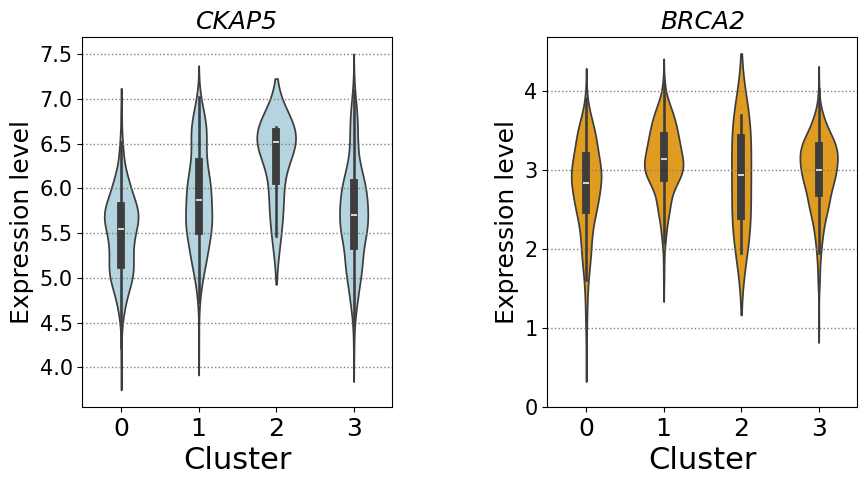

In [40]:

exp_level = train_image.sum((2,3))
fig, ax = plt.subplots(1, 2, figsize=(10, 4.8),  gridspec_kw={ "wspace": 0.5})
marker_gene_G2M ='CKAP5'
exp_level_0 = np.array(exp_level[subcluster_labels ==0][:,gene_names.index(marker_gene_G2M)])
exp_level_1 = np.array(exp_level[subcluster_labels ==1][:,gene_names.index(marker_gene_G2M)])
exp_level_2 = np.array(exp_level[subcluster_labels ==2][:,gene_names.index(marker_gene_G2M)])
exp_level_3 = np.array(exp_level[subcluster_labels ==3][:,gene_names.index(marker_gene_G2M)])
print("G2M marker gene:",marker_gene_G2M)
print("exp_level_0:",np.median(exp_level_0))
print("exp_level_1:",np.median(exp_level_1))
print("exp_level_2:",np.median(exp_level_2))
print("exp_level_3:",np.median(exp_level_3))
sns.violinplot([np.log1p(exp_level_0),np.log1p(exp_level_1),np.log1p(exp_level_2),np.log1p(exp_level_3)], color='lightblue', width=0.5,ax=ax[0])
ax[0].set_title(f"{marker_gene_G2M}",fontsize=18,fontstyle='italic')

marker_gene_S ='BRCA2'
exp_level_0 = np.array(exp_level[subcluster_labels ==0][:,gene_names.index(marker_gene_S)])
exp_level_1 = np.array(exp_level[subcluster_labels ==1][:,gene_names.index(marker_gene_S)])
exp_level_2 = np.array(exp_level[subcluster_labels ==2][:,gene_names.index(marker_gene_S)])
exp_level_3 = np.array(exp_level[subcluster_labels ==3][:,gene_names.index(marker_gene_S)])
print("S marker gene:",marker_gene_S)
print("exp_level_0:",np.median(exp_level_0))
print("exp_level_1:",np.median(exp_level_1))
print("exp_level_2:",np.median(exp_level_2))
print("exp_level_3:",np.median(exp_level_3))
sns.violinplot([np.log1p(exp_level_0),np.log1p(exp_level_1),np.log1p(exp_level_2),np.log1p(exp_level_3)], color='orange', width=0.5,ax=ax[1])
ax[1].set_title(f"{marker_gene_S}",fontsize=18,fontstyle='italic')

ax[0].set_xticks([0,1,2,3], [0,1,2,3],fontsize=18)
ax[0].set_yticks(np.arange(4, 8,0.5), ['4.0','4.5','5.0','5.5','6.0','6.5','7.0','7.5'],fontsize=15)
ax[0].grid(axis='y', color='gray', linestyle=':',linewidth=1)
ax[0].set_xlabel('Cluster', fontsize=22)
ax[0].set_ylabel('Expression level', fontsize=18)
ax[1].set_xticks([0,1,2,3], [0,1,2,3],fontsize=18)
ax[1].set_yticks(np.arange(0, 5, 1), ['0','1','2','3','4'],fontsize=15)
ax[1].grid(axis='y', color='gray', linestyle=':',linewidth=1)
ax[1].set_xlabel('Cluster', fontsize=22)

ax[1].set_ylabel('Expression level', fontsize=18)
plt.show()

In [ ]:
embeddings_np  = all_embeddings_train.cpu().numpy()
gene_idx = [gene_names.index(i)  for i in gene_names]
gene_similarity_all = np.zeros((4, len(gene_names), len(gene_names)))


embeddings_train_cell_cycle_i = embeddings_np[subcluster_labels == 0]
embeddings_train_cell_cycle_i_interested = embeddings_train_cell_cycle_i[:,gene_idx]
train_count_sum  = train_image[subcluster_labels == 0].sum(axis=(-1,-2))
num_cells, num_genes, embedding_dim = embeddings_train_cell_cycle_i.shape
gene_similarity = np.zeros((len(gene_names), len(gene_names)))

for cell in tqdm(range(num_cells)):
    gene_similarity_i = np.zeros((len(gene_names), len(gene_names)))
    distances = cdist(embeddings_train_cell_cycle_i_interested[cell], embeddings_train_cell_cycle_i[cell], metric='cosine')
    idx = 0 
    for gene in gene_names:
        if train_count_sum[cell][gene_idx][idx]!=0:
            most_similar_genes = np.argsort(distances[idx])[1:11]  # Exclude self-distance
            for j in most_similar_genes:
                if gene_names[j] in gene_names:
                    gene_similarity_i[gene_names.index(gene), gene_names.index(gene_names[j])] = 1
        idx += 1
    gene_similarity += gene_similarity_i
gene_similarity = gene_similarity/ ((train_count_sum!=0).sum(axis=0)[gene_idx]).reshape(-1,1).repeat(len(gene_names), axis=1)
gene_similarity_sym =  np.maximum(gene_similarity, gene_similarity.T)
gene_similarity_all[0] = gene_similarity_sym

embeddings_train_cell_cycle_i = embeddings_np[subcluster_labels == 1]
embeddings_train_cell_cycle_i_interested = embeddings_train_cell_cycle_i[:,gene_idx]
train_count_sum  = train_image[subcluster_labels == 1].sum(axis=(-1,-2))
num_cells, num_genes, embedding_dim = embeddings_train_cell_cycle_i.shape
gene_similarity = np.zeros((len(gene_names), len(gene_names)))
for cell in tqdm(range(num_cells)):
    gene_similarity_i = np.zeros((len(gene_names), len(gene_names)))
    distances = cdist(embeddings_train_cell_cycle_i_interested[cell], embeddings_train_cell_cycle_i[cell], metric='cosine')
    idx = 0 
    for gene in gene_names:
        if train_count_sum[cell][gene_idx][idx]!=0:
            most_similar_genes = np.argsort(distances[idx])[1:11]  # Exclude self-distance
            for j in most_similar_genes:
                if gene_names[j] in gene_names:
                    gene_similarity_i[gene_names.index(gene), gene_names.index(gene_names[j])] = 1
        idx += 1
    gene_similarity += gene_similarity_i
gene_similarity = gene_similarity/ ((train_count_sum!=0).sum(axis=0)[gene_idx]).reshape(-1,1).repeat(len(gene_names), axis=1)
gene_similarity_sym =  np.maximum(gene_similarity, gene_similarity.T)
gene_similarity_all[1] = gene_similarity_sym

embeddings_train_cell_cycle_i = embeddings_np[subcluster_labels == 2]
embeddings_train_cell_cycle_i_interested = embeddings_train_cell_cycle_i[:,gene_idx]
train_count_sum  = train_image[subcluster_labels == 2].sum(axis=(-1,-2))
num_cells, num_genes, embedding_dim = embeddings_train_cell_cycle_i.shape
gene_similarity = np.zeros((len(gene_names), len(gene_names)))
for cell in tqdm(range(num_cells)):
    gene_similarity_i = np.zeros((len(gene_names), len(gene_names)))
    distances = cdist(embeddings_train_cell_cycle_i_interested[cell], embeddings_train_cell_cycle_i[cell], metric='cosine')
    idx = 0 
    for gene in gene_names:
        if train_count_sum[cell][gene_idx][idx]!=0:
            most_similar_genes = np.argsort(distances[idx])[1:11]  # Exclude self-distance
            for j in most_similar_genes:
                if gene_names[j] in gene_names:
                    gene_similarity_i[gene_names.index(gene), gene_names.index(gene_names[j])] = 1
        idx += 1
    gene_similarity += gene_similarity_i
gene_similarity = gene_similarity/ ((train_count_sum!=0).sum(axis=0)[gene_idx]).reshape(-1,1).repeat(len(gene_names), axis=1)
gene_similarity_sym =  np.maximum(gene_similarity, gene_similarity.T)
gene_similarity_all[2] = gene_similarity_sym


embeddings_train_cell_cycle_i = embeddings_np[subcluster_labels == 3]
embeddings_train_cell_cycle_i_interested = embeddings_train_cell_cycle_i[:,gene_idx]
train_count_sum  = train_image[subcluster_labels == 3].sum(axis=(-1,-2))
num_cells, num_genes, embedding_dim = embeddings_train_cell_cycle_i.shape
most_similar_genes_all_cells = {gene: [] for gene in gene_names}
gene_similarity = np.zeros((len(gene_names), len(gene_names)))
for cell in tqdm(range(num_cells)):
    gene_similarity_i = np.zeros((len(gene_names), len(gene_names)))
    distances = cdist(embeddings_train_cell_cycle_i_interested[cell], embeddings_train_cell_cycle_i[cell], metric='cosine')
    idx = 0 
    for gene in gene_names:
        if train_count_sum[cell][gene_idx][idx]!=0:
            most_similar_genes = np.argsort(distances[idx])[1:11]  # Exclude self-distance
            for j in most_similar_genes:
                if gene_names[j] in gene_names:
                    gene_similarity_i[gene_names.index(gene), gene_names.index(gene_names[j])] = 1
        idx += 1
    gene_similarity += gene_similarity_i
gene_similarity = gene_similarity/ ((train_count_sum!=0).sum(axis=0)[gene_idx]).reshape(-1,1).repeat(len(gene_names), axis=1)
gene_similarity_sym =  np.maximum(gene_similarity, gene_similarity.T)
gene_similarity_all[3] = gene_similarity_sym

100%|██████████| 335/335 [00:01<00:00, 231.74it/s]


In [46]:
upper_triangle = np.triu(gene_similarity_all[0])
gene_pairs_30_cluster_0 = []
for i in range(30):
    idx1,idx2 = np.where(upper_triangle == np.max(upper_triangle))
    idx1,idx2 = idx1[0],idx2[0]
    gene_pairs_30_cluster_0.append((gene_names[idx1],gene_names[idx2]))
    upper_triangle[idx1,idx2] = 0
print(gene_pairs_30_cluster_0)
    
upper_triangle = np.triu(gene_similarity_all[1])
gene_pairs_30_cluster_1 = []
for i in range(30):
    idx1,idx2 = np.where(upper_triangle == np.max(upper_triangle))
    idx1,idx2 = idx1[0],idx2[0]
    gene_pairs_30_cluster_1.append((gene_names[idx1],gene_names[idx2]))
    upper_triangle[idx1,idx2] = 0
print(gene_pairs_30_cluster_1)

upper_triangle = np.triu(gene_similarity_all[2])
gene_pairs_30_cluster_2 = [] 
for i in range(30):
    idx1,idx2 = np.where(upper_triangle == np.max(upper_triangle))
    idx1,idx2 = idx1[0],idx2[0]
    gene_pairs_30_cluster_2.append((gene_names[idx1],gene_names[idx2]))
    upper_triangle[idx1,idx2] = 0
print(gene_pairs_30_cluster_2)

upper_triangle = np.triu(gene_similarity_all[3])
gene_pairs_30_cluster_3 = []
for i in range(30):
    idx1,idx2 = np.where(upper_triangle == np.max(upper_triangle))
    idx1,idx2 = idx1[0],idx2[0]
    gene_pairs_30_cluster_3.append((gene_names[idx1],gene_names[idx2]))
    upper_triangle[idx1,idx2] = 0
print(gene_pairs_30_cluster_3)

[('NOTCH2', 'THBS1'), ('LRP1', 'THBS1'), ('COL5A1', 'THBS1'), ('PRPF8', 'TLN1'), ('FASN', 'TLN1'), ('FBN2', 'THBS1'), ('IGF2R', 'THBS1'), ('FBN2', 'NOTCH2'), ('COL5A1', 'LRP1'), ('COL5A1', 'FBN2'), ('FASN', 'PRPF8'), ('PRKDC', 'TLN1'), ('COL5A1', 'NOTCH2'), ('FBN2', 'LRP1'), ('LRP1', 'NOTCH2'), ('TLN1', 'USP9X'), ('PLXNA1', 'THBS1'), ('CKAP5', 'TLN1'), ('IGF2R', 'NOTCH2'), ('IGF2R', 'LRP1'), ('FASN', 'PRKDC'), ('FBN2', 'IGF2R'), ('NOTCH2', 'PLXNA1'), ('COL5A1', 'IGF2R'), ('PRKDC', 'PRPF8'), ('SRRM2', 'TNRC6A'), ('LMTK2', 'THBS1'), ('CREBBP', 'TLN1'), ('SPTBN1', 'TLN1'), ('CKAP5', 'FASN')]
[('LRP1', 'THBS1'), ('PRPF8', 'TLN1'), ('NOTCH2', 'THBS1'), ('COL5A1', 'THBS1'), ('FBN2', 'THBS1'), ('FASN', 'TLN1'), ('COL5A1', 'LRP1'), ('IGF2R', 'THBS1'), ('LRP1', 'NOTCH2'), ('FBN2', 'LRP1'), ('COL5A1', 'FBN2'), ('FASN', 'PRPF8'), ('COL5A1', 'NOTCH2'), ('IGF2R', 'NOTCH2'), ('PLXNA1', 'THBS1'), ('FBN2', 'NOTCH2'), ('IGF2R', 'LRP1'), ('TLN1', 'USP9X'), ('FBN2', 'IGF2R'), ('PRKDC', 'TLN1'), ('COL5A1'

In [47]:
gene_pair_label = []
union_pair= set(gene_pairs_30_cluster_0) | set(gene_pairs_30_cluster_1) | set(gene_pairs_30_cluster_2) | set(gene_pairs_30_cluster_3)
union_pair = list(union_pair)
for i in union_pair:
    gene_pair_label_i = []
    if i in gene_pairs_30_cluster_0:
        gene_pair_label_i.append('Cluster 0')
    if i in gene_pairs_30_cluster_1:
        gene_pair_label_i.append('Cluster 1')
    if i in gene_pairs_30_cluster_2:
        gene_pair_label_i.append('Cluster 2')
    if i in gene_pairs_30_cluster_3:
        gene_pair_label_i.append('Cluster 3')
    gene_pair_label.append(gene_pair_label_i)


In [68]:
set(gene_pairs_30_cluster_0) & set(gene_pairs_30_cluster_1) & set(gene_pairs_30_cluster_2) & set(gene_pairs_30_cluster_3)

{('CKAP5', 'TLN1'),
 ('FASN', 'PRPF8'),
 ('NOTCH2', 'THBS1'),
 ('PRKDC', 'TLN1'),
 ('SRRM2', 'TNRC6A')}

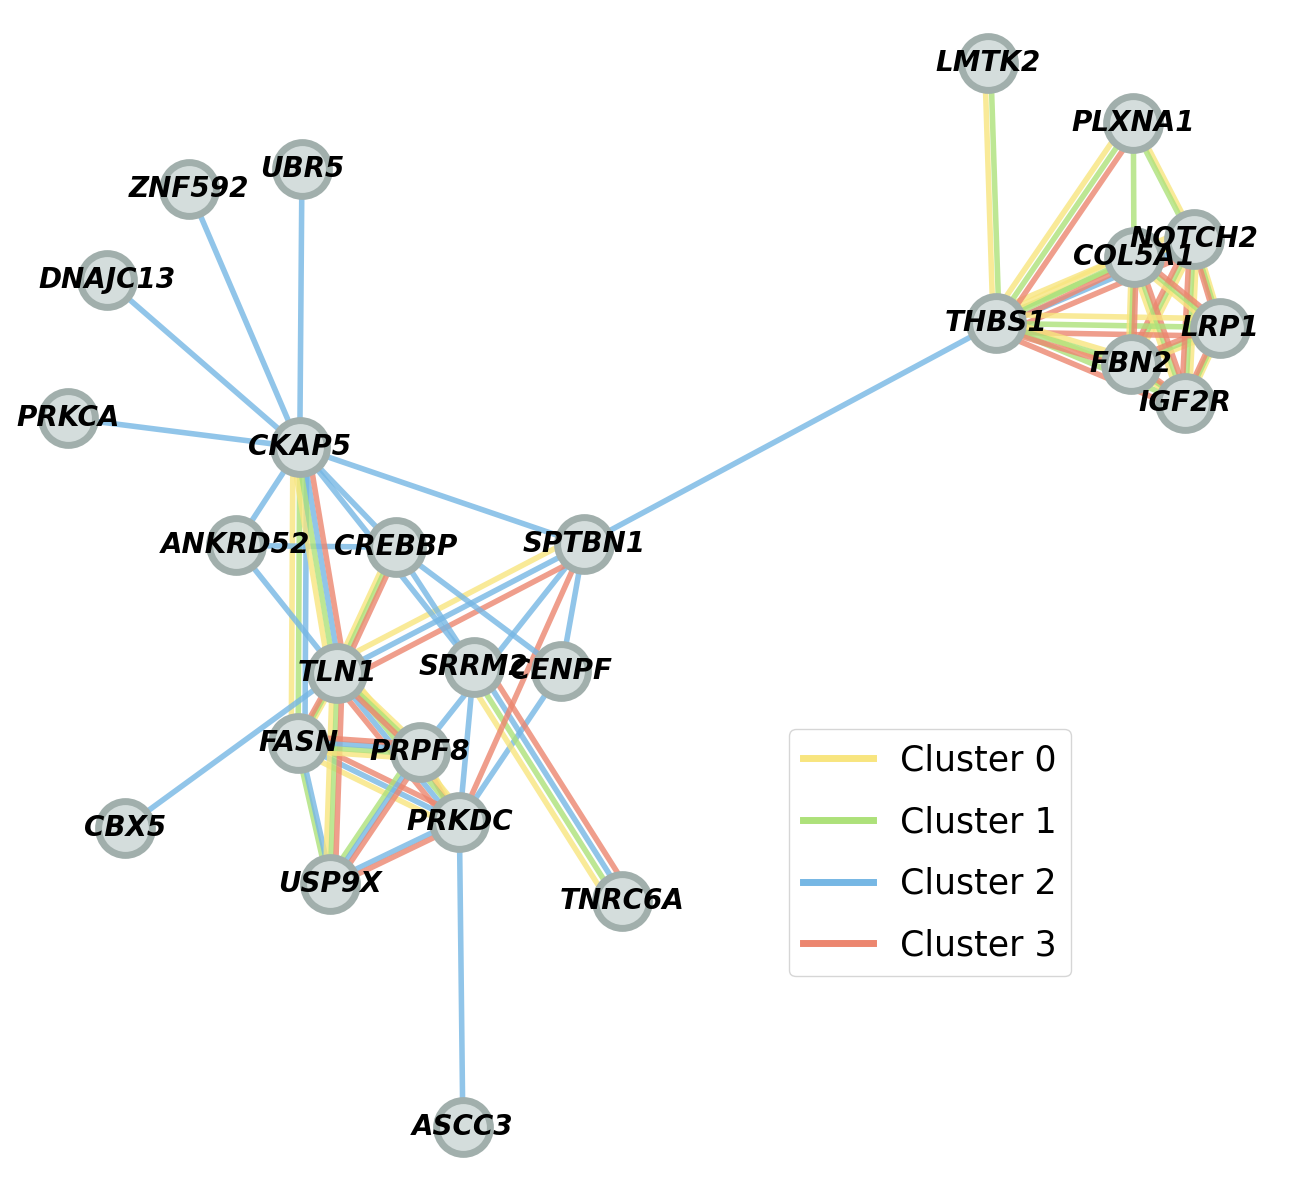

In [71]:
import networkx as nx
from matplotlib.lines import Line2D

G = nx.Graph()
G.add_edges_from(union_pair)

components = list(nx.connected_components(G))
G_sub = G.subgraph(components[0]).copy()

edge_to_labels = {}
for e, labs in zip(union_pair, gene_pair_label):
    if e not in G_sub.edges:
        continue

    if isinstance(labs, str):
        labs_list = [x.strip() for x in labs.split(";")]
    else:
        labs_list = list(labs)

    if e not in edge_to_labels:
        edge_to_labels[e] = []

    for lab in labs_list:
        edge_to_labels[e].append(lab)

unique_labels = ['Cluster 0','Cluster 1', 'Cluster 2', 'Cluster 3']
colors = ['#F8E57F','#ADE17A','#76B7E4','#EC866F']
label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}

pos = nx.spring_layout(G_sub, k=0.3, iterations=100, seed=2024)
fig, ax = plt.subplots(figsize=(13, 12))

for (u, v), labs_list in edge_to_labels.items():
    labs_list = [lab for lab in labs_list if lab in unique_labels]
    if len(labs_list) == 0:
        continue

    x1, y1 = pos[u]
    x2, y2 = pos[v]

    dx = x2 - x1
    dy = y2 - y1
    length = np.hypot(dx, dy) + 1e-9  

    nx_perp = -dy / length
    ny_perp = dx / length

    m = len(labs_list)
    base = 0.03 
    if m == 1:
        offsets = [0.0]
    else:
        offsets = [(i - (m - 1) / 2) * base for i in range(m)]

    for lab, off in zip(labs_list, offsets):
        ox = nx_perp * off * length
        oy = ny_perp * off * length

        ax.plot(
            [x1 + ox, x2 + ox],
            [y1 + oy, y2 + oy],
            color=label_to_color[lab],
            linewidth=4,
            alpha=0.8,
        )

nx.draw_networkx_nodes(G_sub, pos, node_color='#D4DDDC', node_size=1500, ax=ax, edgecolors = '#A1AFAC',linewidths=5)
texts = nx.draw_networkx_labels(
    G_sub, pos,
    font_size=20,
    font_color="black",
    font_weight="bold",
    ax=ax
)

for t in texts.values():
    t.set_fontstyle("italic")   

handles = [Line2D([0], [0], color=label_to_color[l], lw=5) for l in unique_labels]
ax.legend(handles, unique_labels, fontsize=25, bbox_to_anchor=(0.6, 0.4), ncol=1,labelspacing=0.8)

ax.set_axis_off()
plt.tight_layout()
plt.show()


In [72]:
cluster_0_specific_pair = []
cluster_1_specific_pair = []
cluster_2_specific_pair = []
cluster_3_specific_pair = []
for i in gene_pair_label:
    if i == ['Cluster 0']:
        cluster_0_specific_pair.append(i)
    if i == ['Cluster 1']:
        cluster_1_specific_pair.append(i)
    if i == ['Cluster 2']:
        cluster_2_specific_pair.append(i)
    if i == ['Cluster 3']:
        cluster_3_specific_pair.append(i)
print("number of cluster 0 specific pairs:", len(cluster_0_specific_pair))
print("number of cluster 1 specific pairs:", len(cluster_1_specific_pair))
print("number of cluster 2 specific pairs:", len(cluster_2_specific_pair))
print("number of cluster 3 specific pairs:", len(cluster_3_specific_pair))

number of cluster 0 specific pairs: 0
number of cluster 1 specific pairs: 1
number of cluster 2 specific pairs: 19
number of cluster 3 specific pairs: 1


In [73]:
gene_pairs_30_cluster_3_gene = set()
for i in gene_pairs_30_cluster_3:
    gene_pairs_30_cluster_3_gene.add(i[0])
    gene_pairs_30_cluster_3_gene.add(i[1])
for i in gene_pairs_30_cluster_3_gene:
    print(i)

CKAP5
FBN2
PRPF8
COL5A1
USP9X
NOTCH2
IGF2R
TNRC6A
FASN
TLN1
PLXNA1
LRP1
SPTBN1
THBS1
CREBBP
SRRM2
PRKDC


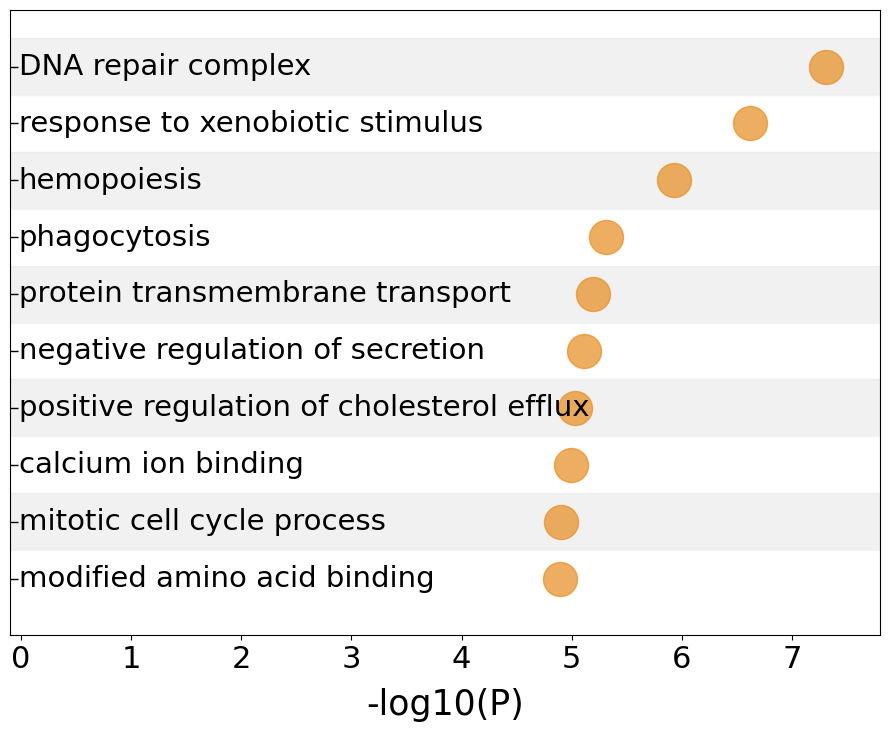

In [6]:
from matplotlib.colors import Normalize
df_gene_pairs_50_cluster_3 = pd.read_excel(f'{data_path}output/merfish_U2OS/GO_enrich_Merfish_U2OS_abnormal.xlsx', sheet_name=None, engine="openpyxl")   
df_gene_pairs_50_cluster_3 = df_gene_pairs_50_cluster_3['Sheet1'] 
# df_gene_pairs_50_cluster_3.loc[
#     df_gene_pairs_50_cluster_3['Description'] == 'regulation of transmembrane receptor protein serine/threonine kinase signaling pathway',
#     'Description'
# ] = 'regulation of serine/threonine receptor signaling'

y_labels = df_gene_pairs_50_cluster_3['Description']
x_vals = -df_gene_pairs_50_cluster_3['Log10(P)']

y_pos = range(0, len(y_labels))

fig, ax = plt.subplots(figsize=(9, 7))

for y in y_pos:
    ax.axhspan(y - 0.5, y + 0.5, color='lightgray' if y % 2 == 0 else 'white', alpha=0.3, zorder=0)

ax.scatter(x_vals, y_pos, color='#e88c1f', s=600, alpha=0.7, zorder=2)

ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels, fontsize=10)
ax.invert_yaxis()
ax.set_xlabel('-log10(P)', fontsize=12)
ax.set_xlim(min(x_vals)-0.5, max(x_vals)+0.5)
ax.tick_params(
    axis='y',         
    direction='in',  
    length=6,         
    width=1,          
    left=True,        
    right=False       
)
ax.set_yticklabels([]) 
for y, label in zip(list(y_pos), y_labels):
    ax.text(
        0.01, y, label,                      
        transform=ax.get_yaxis_transform(),    
        va='center',
        ha='left',
        fontsize=21,
        color='black',
        clip_on=False
    )
plt.tight_layout()
ax.set_xlim(-0.1,7.8)
ax.set_xticks(np.arange(0, 7.1, 1))
ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7], fontsize=22)
ax.set_xlabel('-log10(P)', fontsize=25, labelpad=10)
plt.show()


In [74]:
merfish_U2OS_transcripts = pd.read_csv(f"{data_path}/{dataset}/merfish_U2OS_transcripts.gz")
print(merfish_U2OS_transcripts.head())

   Unnamed: 0          x           y    gene  cell  nucleus  batch  \
0           4  1541.7509  124.650345  AKAP11  11-0       -1      0   
1           5  1526.9758  248.519300  AKAP11  11-0       -1      0   
2           6  1739.5340  363.478000  AKAP11  11-0        3      0   
3           7  1420.0725  542.724060  AKAP11  16-0        7      0   
4           8  1452.2424  563.947270  AKAP11  16-0        7      0   

       centerX     centerY  distance_to_center  direction_vec  contour_x  \
0  1671.135135  332.172973          244.552492         -122.0       1522   
1  1671.135135  332.172973          166.672886         -150.0       1475   
2  1671.135135  332.172973           75.222400           24.5       1873   
3  1419.788360  559.216931           16.495319          -89.0       1428   
4  1419.788360  559.216931           32.796964            8.5       1674   

   contour_y  distance_to_center2     ratio  angle_radians    x_norm    y_norm  
0         94            36.462881  0.8702

In [75]:
cell_mask_contour = pd.read_pickle(f"{data_path}/{dataset}/cell_mask_contour_preprocessed.pkl")
print(cell_mask_contour.head())
nuclear_mask_contour = pd.read_pickle(f"{data_path}/{dataset}/nuclear_mask_contour_preprocessed.pkl")
print(nuclear_mask_contour.head())

   cell      x     y     centerX     centerY  direction_vec  \
0  0-32  621.0  59.0  679.482759  163.641379         -119.0   
1  0-32  621.0  71.0  679.482759  163.641379         -122.5   
2  0-32  586.0  71.0  679.482759  163.641379         -135.5   
3  0-32  586.0  82.0  679.482759  163.641379         -139.0   
4  0-32  551.0  82.0  679.482759  163.641379         -147.5   

   distance_to_center  
0          119.875149  
1          109.556644  
2          131.610985  
3          124.114226  
4          152.227245  
   cell      x     y     centerX     centerY
0  0-32  659.0  86.0  679.482759  163.641379
1  0-32  659.0  88.0  679.482759  163.641379
2  0-32  651.0  88.0  679.482759  163.641379
3  0-32  651.0  91.0  679.482759  163.641379
4  0-32  646.0  91.0  679.482759  163.641379


In [ ]:
def draw_close_point(points):
    center = np.mean(points, axis=0)
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])

    sorted_indices = np.argsort(angles)
    sorted_points = points[sorted_indices]

    closed_points = np.vstack([sorted_points, sorted_points[0]])
    return closed_points


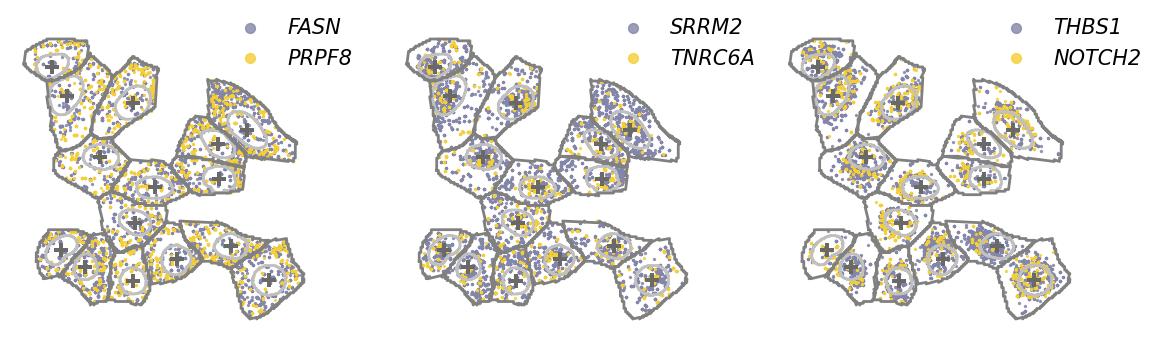

In [77]:

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
batch='0'
preserve_idx_data =[]
for i in merfish_U2OS_transcripts.cell:
    if i.split('-')[1] == batch:
        preserve_idx_data.append(True)
    else:
        preserve_idx_data.append(False)
        
preserve_idx_data = np.array(preserve_idx_data)
cell_ids = [i for i in cell_mask_contour.cell.unique() if i.endswith(f'-{batch}')]
merfish_U2OS_transcripts_i = merfish_U2OS_transcripts[preserve_idx_data]
gene1 ='FASN'
merfish_U2OS_transcripts_i_gene1 = merfish_U2OS_transcripts_i[merfish_U2OS_transcripts_i.gene == gene1]

gene2 ='PRPF8'
merfish_U2OS_transcripts_i_gene2 = merfish_U2OS_transcripts_i[merfish_U2OS_transcripts_i.gene == gene2]

gene3 ='SRRM2'
merfish_U2OS_transcripts_i_gene3 = merfish_U2OS_transcripts_i[merfish_U2OS_transcripts_i.gene == gene3]

gene4 ='TNRC6A'
merfish_U2OS_transcripts_i_gene4 = merfish_U2OS_transcripts_i[merfish_U2OS_transcripts_i.gene == gene4]

gene5 ='THBS1'
merfish_U2OS_transcripts_i_gene5 = merfish_U2OS_transcripts_i[merfish_U2OS_transcripts_i.gene == gene5]

gene6 ='NOTCH2'
merfish_U2OS_transcripts_i_gene6 = merfish_U2OS_transcripts_i[merfish_U2OS_transcripts_i.gene == gene6]

ax[0].scatter(merfish_U2OS_transcripts_i_gene1['x'], merfish_U2OS_transcripts_i_gene1['y'], label=gene1.upper(), alpha=0.8, s=2,color='#8386a8')
ax[0].scatter(merfish_U2OS_transcripts_i_gene2['x'], merfish_U2OS_transcripts_i_gene2['y'], label=gene2.upper(), alpha=0.8, s=2,color='#f5cf36')
leg = ax[0].legend(fontsize=15,markerscale=5,bbox_to_anchor=(0.65, 0.8),frameon=False)
for text in leg.get_texts():
    text.set_fontstyle('italic')

ax[1].scatter(merfish_U2OS_transcripts_i_gene3['x'], merfish_U2OS_transcripts_i_gene3['y'], label=gene3.upper(), alpha=0.8, s=2,color='#8386a8')
ax[1].scatter(merfish_U2OS_transcripts_i_gene4['x'], merfish_U2OS_transcripts_i_gene4['y'], label=gene4.upper(), alpha=0.8, s=2,color='#f5cf36')
leg = ax[1].legend(fontsize=15,markerscale=5,bbox_to_anchor=(0.65, 0.8),frameon=False)
for text in leg.get_texts():
    text.set_fontstyle('italic')
    
ax[2].scatter(merfish_U2OS_transcripts_i_gene5['x'], merfish_U2OS_transcripts_i_gene5['y'], label=gene5.upper(), alpha=0.8, s=2,color='#8386a8')
ax[2].scatter(merfish_U2OS_transcripts_i_gene6['x'], merfish_U2OS_transcripts_i_gene6['y'], label=gene6.upper(), alpha=0.8, s=2,color='#f5cf36')
leg = ax[2].legend(fontsize=15,markerscale=5,bbox_to_anchor=(0.65, 0.8),frameon=False)
for text in leg.get_texts():
    text.set_fontstyle('italic')
for cell_id in cell_ids:
    cell_mask_contour_i= cell_mask_contour[(cell_mask_contour.cell == cell_id)]
    closed_points_cell = draw_close_point(cell_mask_contour_i[['x', 'y']].values)
    nuclear_mask_contour_i = nuclear_mask_contour[(nuclear_mask_contour.cell == cell_id)]
    closed_points_nuclear = draw_close_point(nuclear_mask_contour_i[['x', 'y']].values)

    ax[0].plot(closed_points_nuclear[:, 0], closed_points_nuclear[:, 1], color='silver',linewidth=2)
    ax[0].plot(closed_points_cell[:, 0], closed_points_cell[:, 1], color='grey',linewidth=2)
    ax[0].scatter(cell_mask_contour_i['centerX'], cell_mask_contour_i['centerY'], marker='+', color='dimgray', s=100)
    ax[0].axis('off')
    ax[0].set_aspect('equal', adjustable='box')

    ax[1].plot(closed_points_nuclear[:, 0], closed_points_nuclear[:, 1], color='silver',linewidth=2)
    ax[1].plot(closed_points_cell[:, 0], closed_points_cell[:, 1], color='grey',linewidth=2)
    ax[1].scatter(cell_mask_contour_i['centerX'], cell_mask_contour_i['centerY'], marker='+', color='dimgray', s=100)
    ax[1].axis('off')
    ax[1].set_aspect('equal', adjustable='box')

    ax[2].plot(closed_points_nuclear[:, 0], closed_points_nuclear[:, 1], color='silver',linewidth=2)
    ax[2].plot(closed_points_cell[:, 0], closed_points_cell[:, 1], color='grey',linewidth=2)
    ax[2].scatter(cell_mask_contour_i['centerX'], cell_mask_contour_i['centerY'], marker='+', color='dimgray', s=100)
    ax[2].axis('off')
    ax[2].set_aspect('equal', adjustable='box')
plt.show()

In [ ]:
['0-32', '16-69', '18-32', '21-54', '27-40', '33-21', '38-26',
       '39-15', '39-55', '40-21']

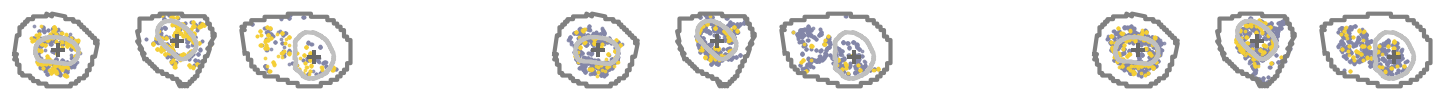

: 

In [ ]:
fig = plt.figure(figsize=(15, 1))

subplot_width = 0.08
subplot_height = 0.8
bottom = 0.1

x_starts = [0, 0.08, 0.16, 0.36, 0.44, 0.52, 0.72, 0.8, 0.88]

axes = []
for x in x_starts:
    ax = fig.add_axes([x, bottom, subplot_width, subplot_height])
    axes.append(ax)

cell_id = ['39-15','16-69','0-32']
gene_id_0 = ['FASN','SRRM2','THBS1']
gene_id_1 = ['PRPF8','TNRC6A','NOTCH2']
    
for i, ax in enumerate(axes):
    cell_id_i = cell_id[i%3]
    merfish_U2OS_transcripts_i = merfish_U2OS_transcripts[(merfish_U2OS_transcripts.cell == cell_id_i)]
    cell_mask_contour_i= cell_mask_contour[(cell_mask_contour.cell == cell_id_i)]
    closed_points_cell = draw_close_point(cell_mask_contour_i[['x', 'y']].values)
    nuclear_mask_contour_i = nuclear_mask_contour[(nuclear_mask_contour.cell == cell_id_i)]
    closed_points_nuclear = draw_close_point(nuclear_mask_contour_i[['x', 'y']].values)
    data_i_gene1 = merfish_U2OS_transcripts_i[merfish_U2OS_transcripts_i.gene == gene_id_0[i//3]]
    data_i_gene2 = merfish_U2OS_transcripts_i[merfish_U2OS_transcripts_i.gene == gene_id_1[i//3]]
    ax.scatter(data_i_gene1['x'], data_i_gene1['y'], label=gene_id_0[i//3].upper(), alpha=0.8, s=3,color='#8386a8')
    ax.scatter(data_i_gene2['x'], data_i_gene2['y'], label=gene_id_1[i//3].upper(), alpha=0.8, s=3,color='#f5cf36')
    ax.plot(closed_points_nuclear[:, 0], closed_points_nuclear[:, 1], color='silver',linewidth=3)
    ax.plot(closed_points_cell[:, 0], closed_points_cell[:, 1], color='grey',linewidth=3)
    ax.scatter(cell_mask_contour_i['centerX'], cell_mask_contour_i['centerY'], marker='+', color='dimgray', s=100)
    ax.axis('off')
    ax.set_aspect('equal', adjustable='box')
plt.show()
